<a href="https://colab.research.google.com/github/rs-delve/covid19_datasets/blob/master/Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# International Dataset Exploratory Analysis
This notebook provides some basic exploratory analysis of a selection of fields available the [DELVE Covid 19 international dataset](https://github.com/rs-delve/covid19_datasets).

We will continue updating this over time and welcome contributions if you have a plot you would like included!

In [0]:
#@title Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output, display
import ipywidgets as widgets
from datetime import datetime, date, timedelta

path = 'https://raw.githubusercontent.com/rs-delve/covid19_datasets/master/dataset/combined_dataset_latest.csv'
df = pd.read_csv(path, parse_dates=['DATE'])

## Non-Pharmaceutical Interventions (NPIs)
The Oxford Government Response Tracker provides 13 NPIs on an ordinal scale for each country, reflecting both the intensity of enforcement of the intervention. We supplement this with an additional "Masks" NPI. 

### Timeline of NPI Introduction for Selected Countries
Here we show, for the 10 countries with the most COVID-19 cases, when each NPI was introduced as a function of the number of days after the first reported case. This gives us a sense of how spread out or clustered the various NPIs were in each country. For example, USA's NPIs are quite spread out over the outbreak, while Spain's are rather clustered around 50 days after the outbreak.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


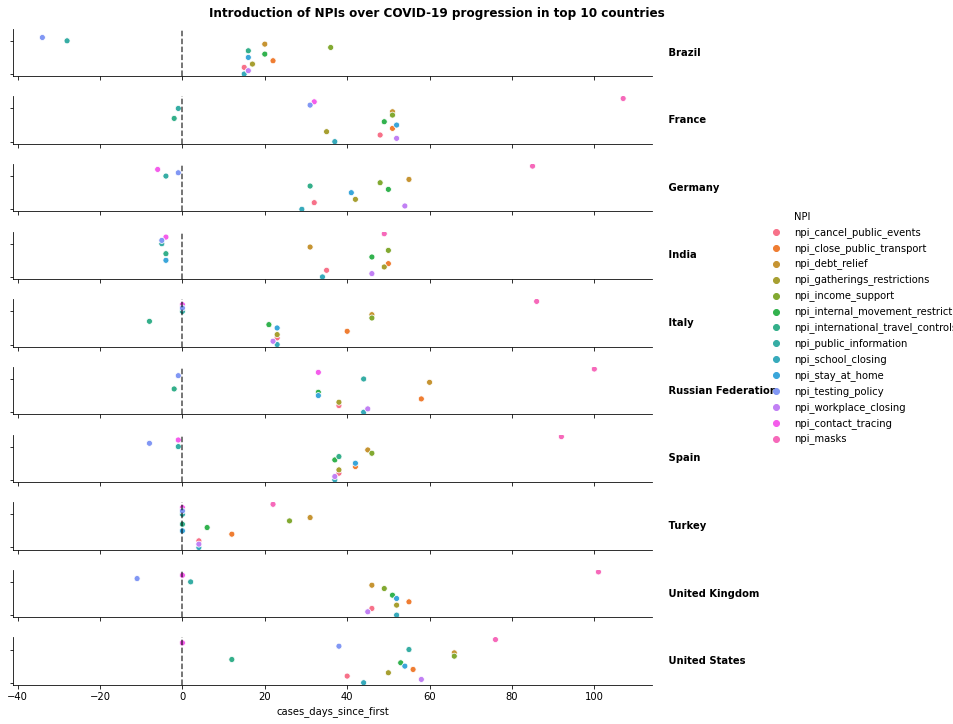

In [2]:
#@title Timeline Plot
npis = [
        'npi_school_closing',
        'npi_workplace_closing',
        'npi_cancel_public_events',
        'npi_gatherings_restrictions',
        'npi_close_public_transport',
        'npi_stay_at_home',
        'npi_internal_movement_restrictions',
        'npi_international_travel_controls',
        'npi_income_support',
        'npi_debt_relief',
        'npi_public_information',
        'npi_testing_policy',
        'npi_contact_tracing',
        'npi_masks',
]

countries = df.groupby('country_name').cases_total.max().nlargest(10).index
plot_df = df[df.country_name.isin(countries)][['country_name', 'cases_days_since_first'] + npis].melt(id_vars=['country_name', 'cases_days_since_first'], var_name='NPI')
plot_df = plot_df.sort_values(['country_name', 'cases_days_since_first'])
plot_df = plot_df[plot_df['value'] > 0].groupby(['country_name', 'NPI'], as_index=False).min()

plot_df['value'] = plot_df.NPI.map({npi: i for i, npi in enumerate(npis)})

g = sns.relplot(data=plot_df, 
                x='cases_days_since_first', 
                y='value', 
                hue='NPI', 
                row='country_name', 
                kind='scatter', 
                height=1, 
                aspect=10, 
                marker='o', 
                facet_kws=dict(margin_titles=True, legend_out=True, despine=True))

for ax in g.axes.flat:
  txt = ax.texts[0]
  ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
          txt.get_text().split('=')[1],
          transform=ax.transAxes,
          va='center',
          fontweight='bold')
  ax.texts[0].remove()
  ax.set_ylabel(None)
  ax.set_yticklabels([])
  ax.axvline(0, ls='--', c='k', alpha=0.7)

g.fig.suptitle('Introduction of NPIs over COVID-19 progression in top 10 countries', fontweight='bold')

leg = g._legend
leg.set_bbox_to_anchor([1.05, 0.55]) 

plt.subplots_adjust(top=0.95)
plt.show()

### Number of countries with each NPI over time
Here we see that some NPIs like "Public information campaigns", "international travel controls" and "School closing" have been implemented by almost all countries in the dataset. The uptake of other NPIs like Masks are must less common. 

**NB**: The dips in the plots around more recent dates highlights an issue with the incompleteness of recent data. This is due to both reporting and capturing delays and doesn't necessarily reflect a lifting of NPIs in countries. The data provider (Oxford) suggests using the latest week or two worth of data with caution. 

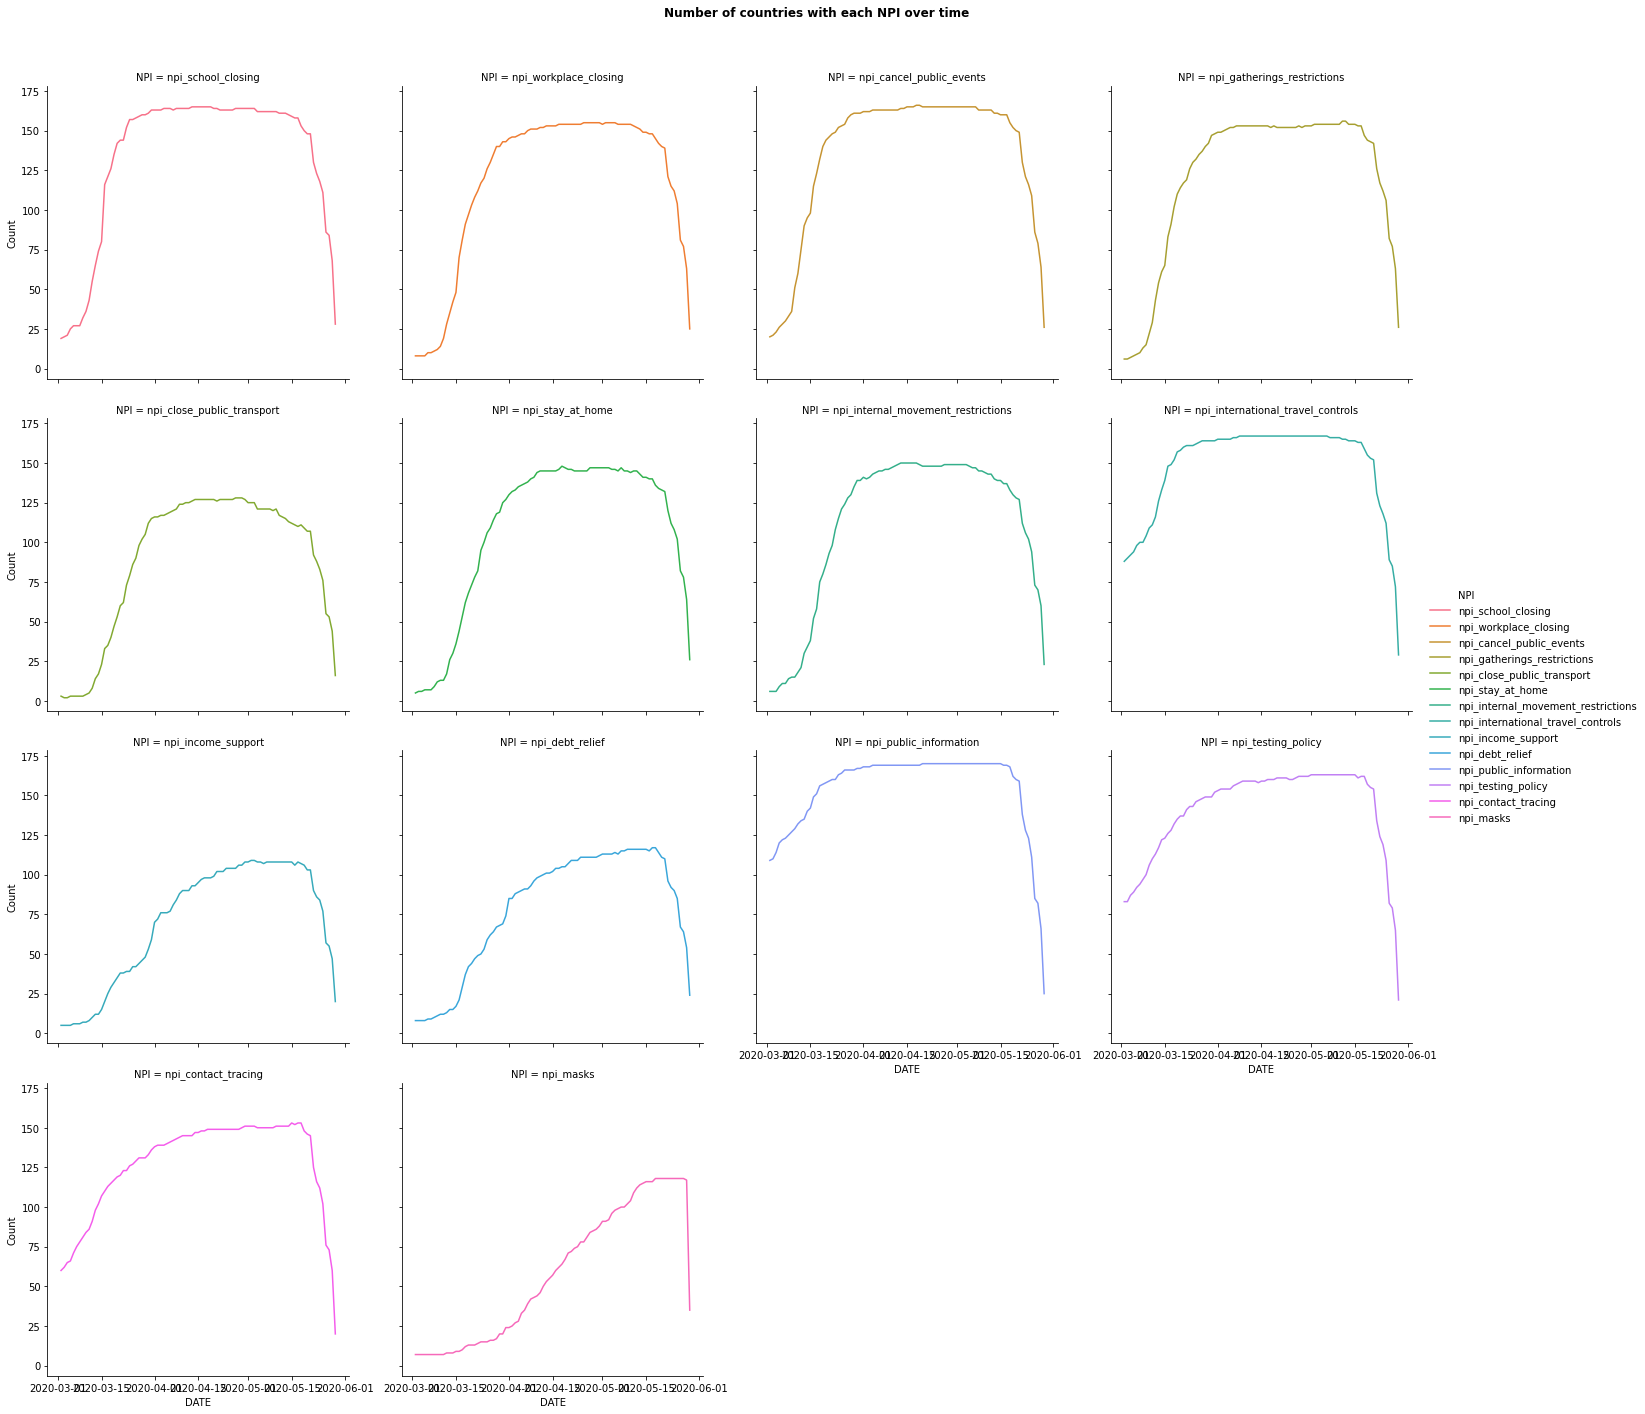

In [3]:
#@title Plot
plot_df = (df.set_index(['DATE', 'ISO'])[npis] > 0).groupby(level=0).sum()
plot_df = plot_df.iloc[:-1].reset_index().melt(id_vars=['DATE'], var_name='NPI', value_name='Count')
plot_df = plot_df.query('DATE > "2020-03-01"')

g = sns.relplot(data=plot_df, x='DATE', y='Count', col='NPI', col_wrap=4, hue='NPI', kind='line')
plt.subplots_adjust(top=0.925)
g.fig.suptitle('Number of countries with each NPI over time', fontweight='bold')
plt.show()

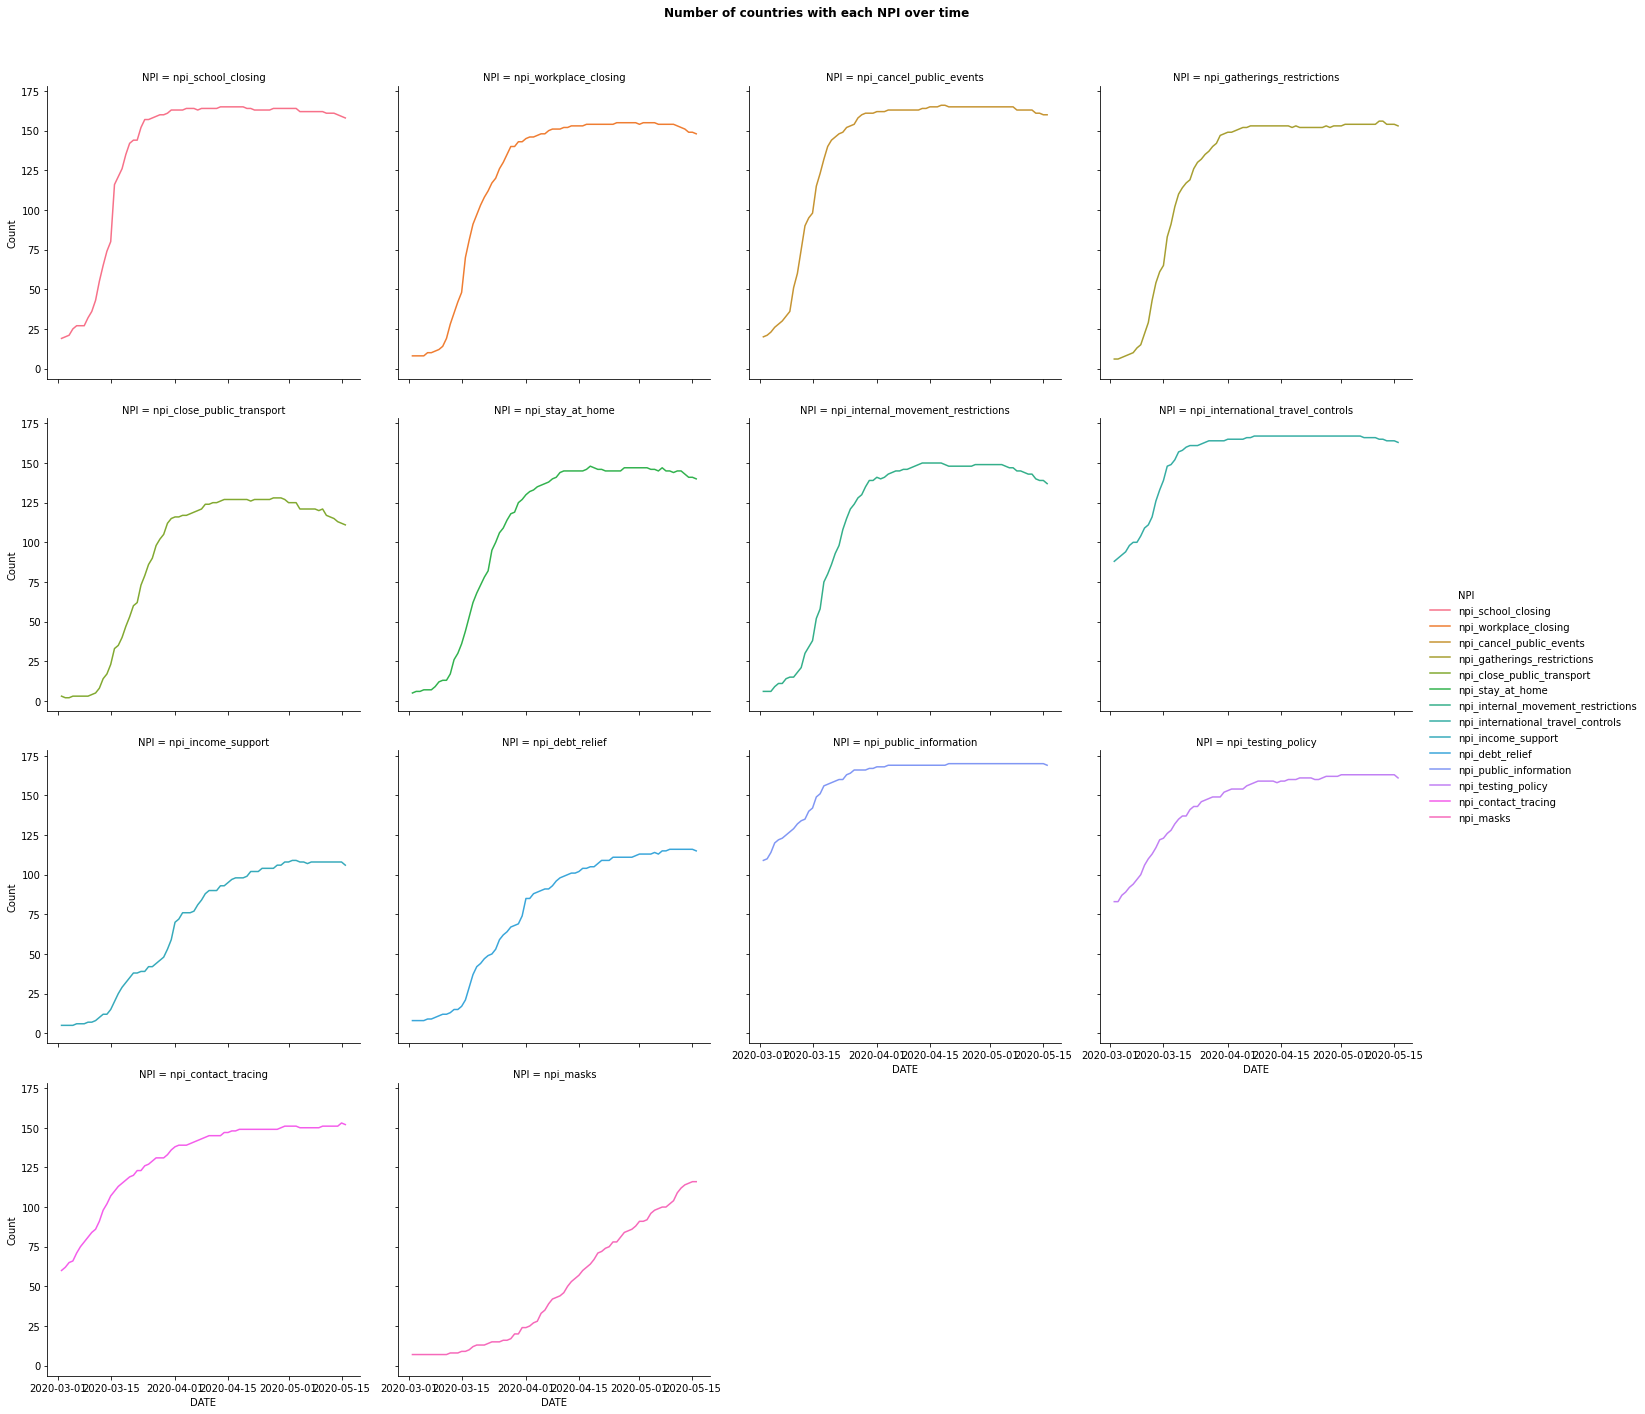

In [6]:
#@title Excluding the last 2 weeks
plot_df = (df.set_index(['DATE', 'ISO'])[npis] > 0).groupby(level=0).sum()
plot_df = plot_df.iloc[:-1].reset_index().melt(id_vars=['DATE'], var_name='NPI', value_name='Count')
two_weeks_ago = (date.today() - timedelta(14)).strftime('%Y-%m-%d')
plot_df = plot_df.query('DATE > "2020-03-01" and DATE < "{}"'.format(two_weeks_ago))
g = sns.relplot(data=plot_df, x='DATE', y='Count', col='NPI', col_wrap=4, hue='NPI', kind='line')
plt.subplots_adjust(top=0.925)
g.fig.suptitle('Number of countries with each NPI over time', fontweight='bold')
plt.show()

## New deaths per day in a selection of countries (log scale)
At a glance it looks like the daily new deaths in these countries is on the decline.

The vertical lines in the plot are on Sundays. It highlights that there are *day of week effects* in this data. For example, Germany and the UK both appear to have dips in new deaths on Mondays.

It is recommended that smoothing or other normalization is applied to these data before conducting analyses.

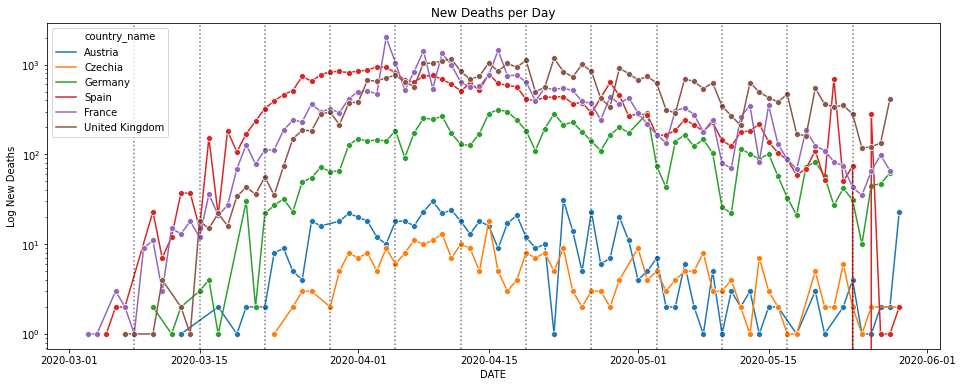

In [9]:
#@title New Deaths Per Day Plot
isos = ['AUT', 'CZE', 'DEU', 'ESP', 'FRA', 'GBR']
start_date = '2020-03-01'
plot_df = df[df.ISO.isin(isos)].query(f'DATE > "{start_date}"').replace(0, np.nan)

sundays = plot_df.DATE[plot_df.DATE.dt.dayofweek == 6]

fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(data=plot_df, x='DATE', y='deaths_new', hue='country_name', marker='o')
plt.yscale('log')
plt.title('New Deaths per Day')
plt.ylabel('Log New Deaths')

for sunday in sundays:
  plt.axvline(sunday, c='k', ls=':', alpha=0.1)

plt.show()



## Smoothed deaths with Stringency Index
**Select a country from the dropdown to re-generate the plot**

Since the number of new deaths depends partially on the day of the week, we take a rolling 7 day centered mean to smooth out this artifact. We provide a function below to add the smoothed count to the data frame should you wish to use this in your own analysis. 

The Oxford Government Response Tracker dataset provides a Stringency Index measure, which is a value between 0 and 100 that summarizes the level of active NPIs in a country.

In [0]:
#@title Add smoothed new cases and deaths
df = df.set_index(['ISO', 'DATE'])

def smooth(series):
  return series.rolling(window=7, center=True).mean()

df.loc[:, 'deaths_new_smoothed'] = df.loc[:, 'deaths_new'].groupby(level=0).apply(smooth)
df.loc[:, 'cases_new_smoothed'] = df.loc[:, 'cases_new'].groupby(level=0).apply(smooth)

df = df.reset_index()

Dropdown(description='Country:', index=161, options=(('Afghanistan', 'Afghanistan'), ('Albania', 'Albania'), (…

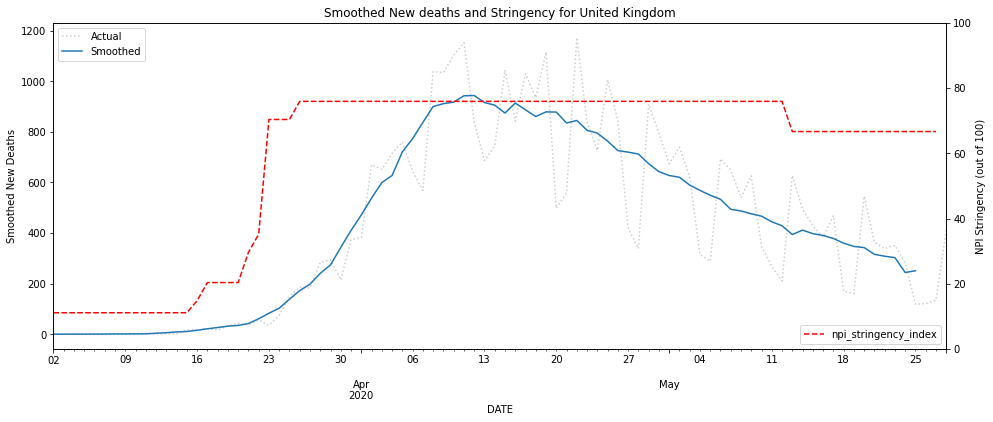

In [10]:
#@title Smoothed Deaths and Stringency plot

def add_widget(country):
  country_widget = widgets.Dropdown(
      options=sorted([(c, c) for c in df.country_name.unique()]),
      value=country,
      description='Country:',
  )

  country_widget.observe(lambda d: plot_country(d['new']), 'value')
  display(country_widget)

def plot_country(country):
  clear_output()
  add_widget(country)
  fig, ax = plt.subplots(figsize=(16, 6))
  ax2 = ax.twinx()
  ax2.set_ylim(0, 100)
  plot_df = df.query(f'country_name == "{country}" and DATE > "{start_date}"').set_index('DATE')
  plot_df.deaths_new.plot(color='k', ls=':', alpha=0.2, label='Actual', ax=ax)
  ax.set_title(f'Smoothed New deaths and Stringency for {country}')

  plot_df.deaths_new_smoothed.plot(label='Smoothed', ax=ax)
  plot_df.npi_stringency_index.plot(legend='Stringency', ax=ax2, c='r', ls='--')

  ax.set_ylabel('Smoothed New Deaths')
  ax2.set_ylabel('NPI Stringency (out of 100)')

  ax.legend(loc=2)
  ax2.legend(loc=4)

plot_country('United Kingdom')

Because of differences in reporting and testing policies, it is difficult to compare COVID-19 case and death figures between countries. One way of addressing this difficulty is to compare rates of change. Another is to compare *excess deaths*, which is defined as the difference between total reported deaths in a country in a week in 2020 and the average number of deaths in the same week over the last 5 years. 

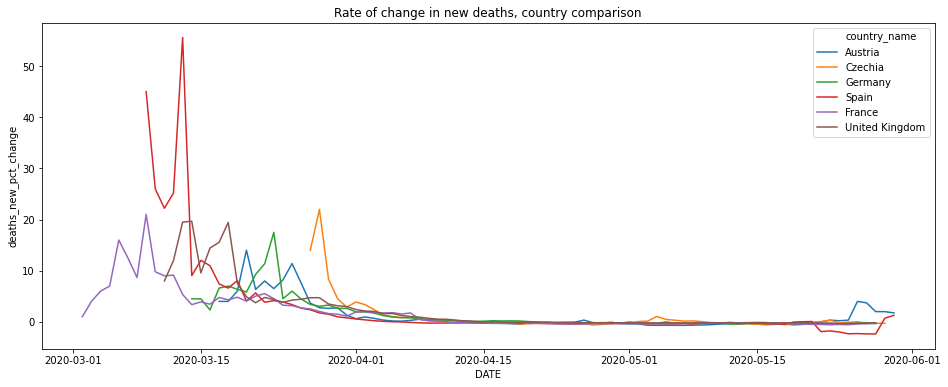

In [19]:
#@title Rates of change (week to week) in deaths
df = df.set_index(['ISO', 'DATE'])
df.loc[:, 'deaths_new_pct_change'] = df.loc[:, 'deaths_new_smoothed'].groupby(level=0).pct_change(periods=7)  
df = df.reset_index()

fig, ax = plt.subplots(figsize=(16, 6))
plot_df = df[df.ISO.isin(isos)].query('DATE > "{}"'.format(start_date))
sns.lineplot(data=plot_df, x='DATE', y='deaths_new_pct_change', hue='country_name')
plt.title('Rate of change in new deaths, country comparison');

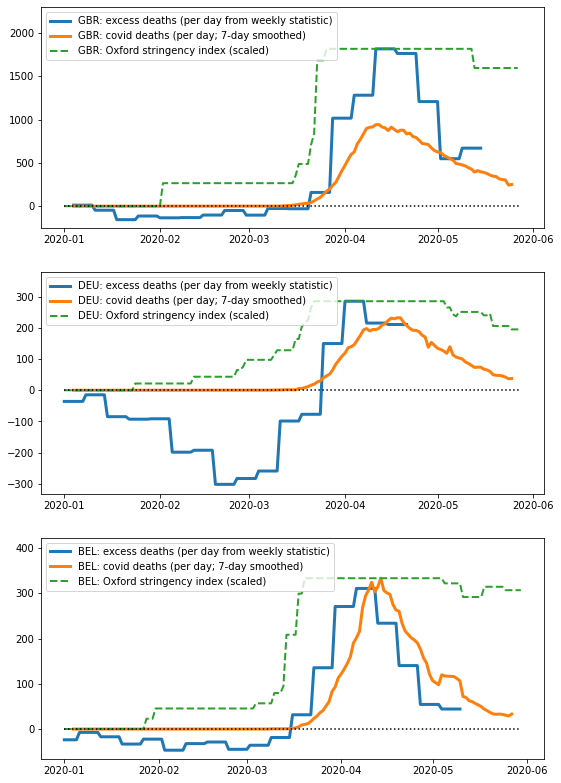

In [21]:
#@title Excess deaths

plot_df = df.set_index(['ISO', 'DATE']).copy()
plot_df['deaths_week_window'] = plot_df['deaths_new'].copy()
plot_df.loc[:, 'deaths_week_window'] = plot_df.loc[:, 'deaths_week_window'].groupby(level=0).apply(lambda rows: rows.rolling(7).sum())
plot_df.loc[:, ['deaths_week_window']] = plot_df.loc[:, ['deaths_week_window']].groupby(level=0).shift(periods=-3)

isos = ['GBR', 'DEU', 'BEL']
fig, ax = plt.subplots(len(isos), 1, figsize=(9, 6 * len(isos)))

for idx in range(len(isos)):
  if len(isos) > 1:
    a = ax[idx]
  else:
    a = ax

  iso = isos[idx]
  ctry = plot_df.loc[iso]
  x = ctry.index                                 # The second index is the date.
  
  y = ctry['deaths_excess_daily_avg']
  maximum = y.max()
  a.plot(x, y, '-', linewidth=3,
         label=iso + ': excess deaths (per day from weekly statistic)')
  
  y = ctry['deaths_week_window'] / 7
  maximum = maximum if maximum > y.max() else y.max()  
  a.plot(x, y, '-', linewidth=3,
         label=iso + ': covid deaths (per day; 7-day smoothed)')           
      
  y = ctry['npi_stringency_index']
  y = y / y.max() * maximum
  a.plot(x, y, '--', linewidth=2,
         label=iso + ': Oxford stringency index (scaled)')      
  
  a.plot(x, np.zeros(x.shape), ':k')
  bottom, top = a.get_ylim()
  a.set_ylim(bottom, 1.2 * top)                     # Space for the long legend.
  fig.subplots_adjust(bottom=0.3)
  a.legend(loc='upper left', fontsize=10)


## Case Fatality Rate (CFR)
The Case Fatality Rate is defined as:
$$\frac{\text{Number of deaths}}{\text{Number of cases}} \times 100$$

We plot it over time for the top 10 countries in terms of case count. 

The fact that it changes over time and varies a lot between countries suggests that when measured using this data, it is confounded by differences in testing and reporting policies between countries.

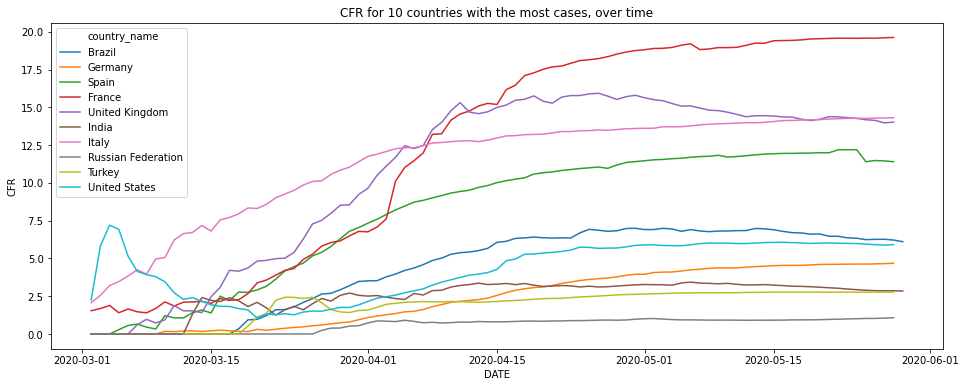

In [0]:
#@title CFR Plot
countries = df.groupby('country_name').cases_total.max().nlargest(10).index
plot_df = df[df.country_name.isin(countries)].copy()
plot_df.loc[:, 'CFR'] = plot_df['deaths_total'] / plot_df['cases_total'] * 100
plot_df = plot_df.query('DATE > "2020-03-01"')

fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(data=plot_df, x='DATE', y='CFR', hue='country_name')
plt.title('CFR for 10 countries with the most cases, over time')
plt.show()

## COVID-19 Tests
The dataset includes data on the number of COVID-19 tests performed. Caution is advised when using this data because it is not populated for all countries, and where it is populated, may not be reported at the same frequency as the number of confirmed cases. The plots below illustrate this 

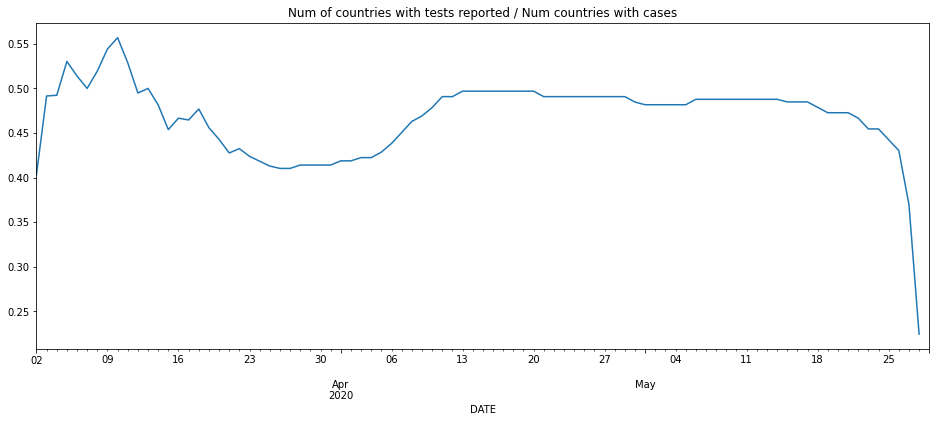

In [0]:
#@title Countries with number of tests data as a proportion of those that have confirmed cases
#@markdown Note that this plot dips as more countries start reporting cases for the first time with the number of cases for those countries being reported later.
fig, ax = plt.subplots(figsize=(16, 6))
countries = df.query(f'DATE > "{start_date}" and cases_total > 0').groupby('DATE')['country_name'].count()
tests = df.query(f'DATE > "{start_date}" and tests_total > 0').groupby('DATE')['country_name'].count()
(tests / countries).plot()
plt.title('Num of countries with tests reported / Num countries with cases')
plt.show()

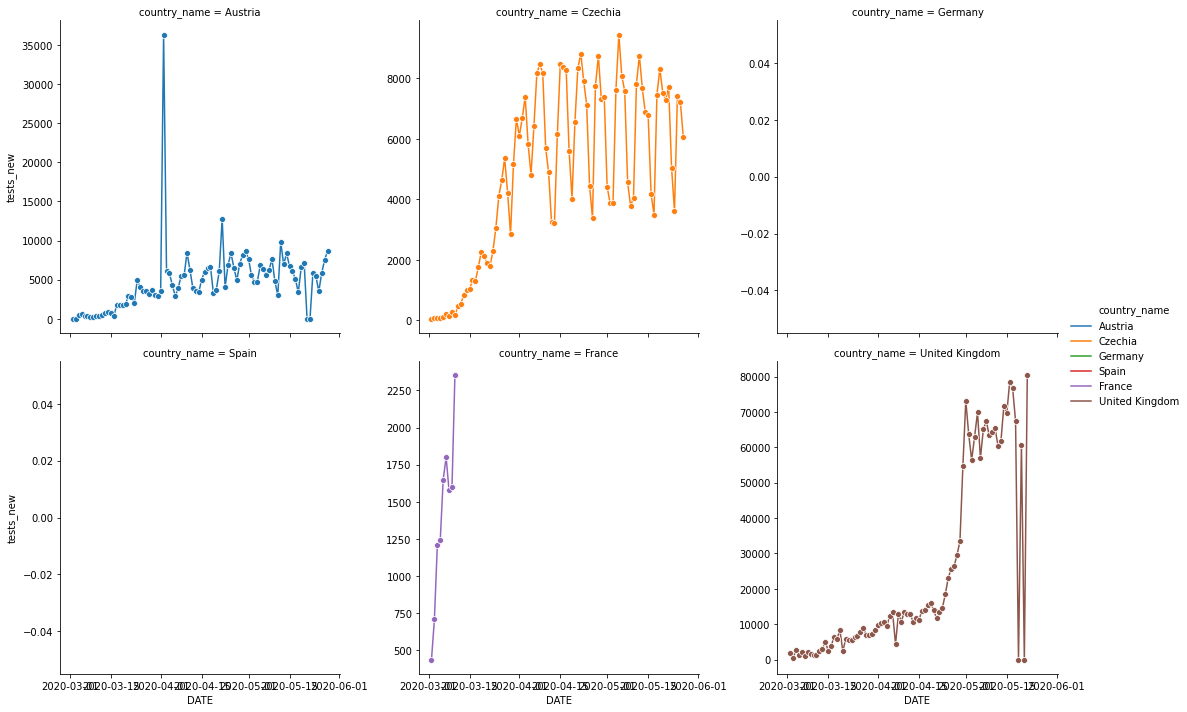

In [0]:
#@title Number of Tests - Artifacts
#@markdown We see large daily variations in the number of new tests, likely due to reporting policies.
#@markdown Some countries only report cumulative test totals in batches (like Germany and Spain) and therefore have no data populated for tests_new.
plot_df = df[(df.ISO.isin(isos)) & (df.DATE > start_date)].set_index(['ISO', 'DATE'])

sns.relplot(data=plot_df.reset_index(), x='DATE', y='tests_new', kind='line', col='country_name', col_wrap=3, marker='o', facet_kws=dict(sharey=False), hue='country_name')
plt.show()



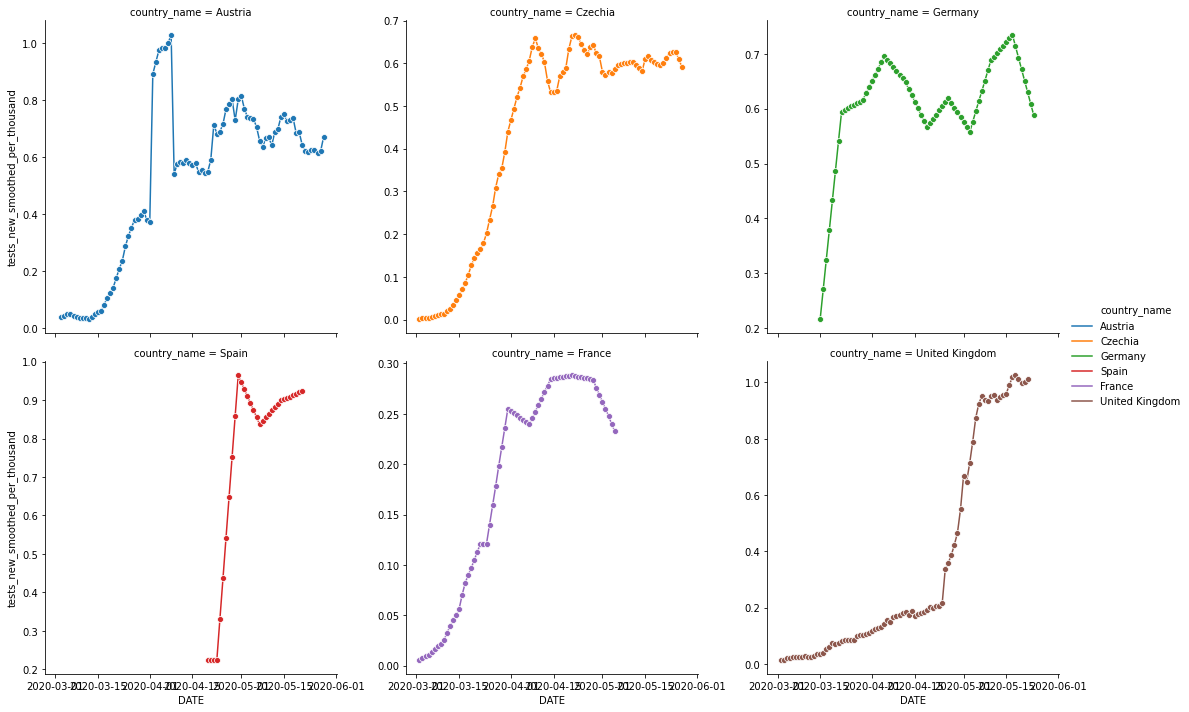

In [0]:
#@title Smoothed Tests
#@markdown The data provider Our World in Data provides a smoothed new tests series that averages over 7 days
plot_df = df[(df.ISO.isin(isos)) & (df.DATE > start_date)].set_index(['ISO', 'DATE'])
sns.relplot(data=plot_df.reset_index(), x='DATE', y='tests_new_smoothed_per_thousand', kind='line', col='country_name', col_wrap=3, marker='o', facet_kws=dict(sharey=False), hue='country_name')
plt.show()

# Mobility
Below we plot mobility trends for a country. Once again you can select a country to display in the dropdown box if running in Jupyter or Colab. 

We see in many countries that residential mobility has increased while workplaces, retail and recreation and transit stations have significantly decreased, likely due to stay at home policies. Mobility to parks has increased substantially in the United Kingdom, possibly due to the improving weather.

Plotting vertical lines on Sundays again reveals a *day of week effect* in this data.

Dropdown(description='Country:', index=161, options=(('Afghanistan', 'Afghanistan'), ('Albania', 'Albania'), (…

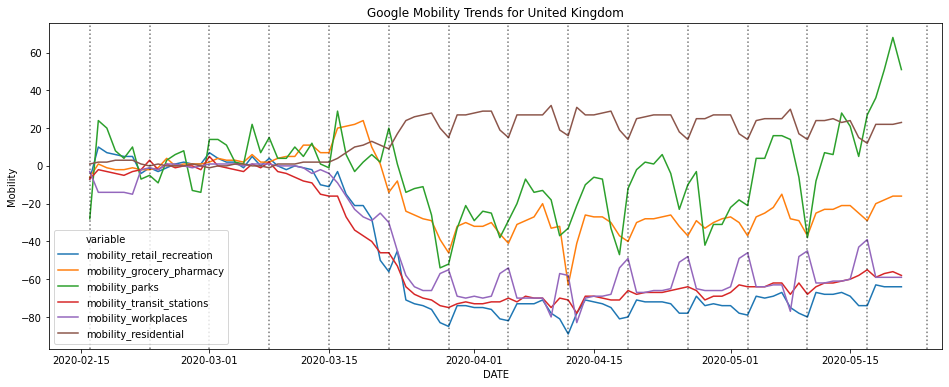

In [0]:
#@title Google Mobilty Trends
google_mobility_columns = [
    'mobility_retail_recreation',
    'mobility_grocery_pharmacy', 
    'mobility_parks',
    'mobility_transit_stations', 
    'mobility_workplaces',
    'mobility_residential'
]

def add_widget(country):
  country_widget = widgets.Dropdown(
      options=sorted([(c, c) for c in df.country_name.unique()]),
      value=country,
      description='Country:',
  )

  country_widget.observe(lambda d: plot_country(d['new']), 'value')
  display(country_widget)

def plot_country(country):
  clear_output()
  add_widget(country)
  plot_df = df[(df.country_name == country) & (df.DATE > '2020-02-15')][['ISO', 'DATE', 'country_name'] + google_mobility_columns]
  plot_df = plot_df.melt(id_vars=['ISO', 'DATE', 'country_name'], value_name='Mobility')

  fig, ax = plt.subplots(figsize=(16, 6))
  sns.lineplot(data=plot_df, x='DATE', y='Mobility', hue='variable')
  plt.title('Google Mobility Trends for {}'.format(plot_df.country_name[0]))

  sundays = plot_df.DATE[plot_df.DATE.dt.dayofweek == 6]
  for sunday in sundays:
    plt.axvline(sunday, c='k', ls=':', alpha=0.1)

plot_country('United Kingdom')

# Weather
The dataset includes precipitation, humidity, short-wave-length radiation (a proxy for sunlight) and temperature 

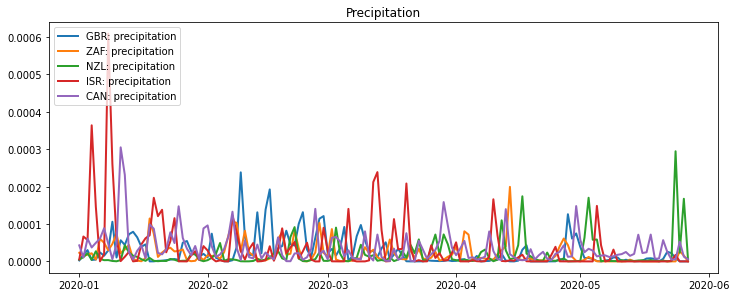

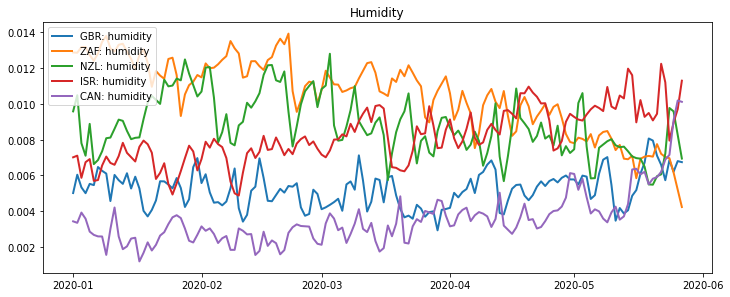

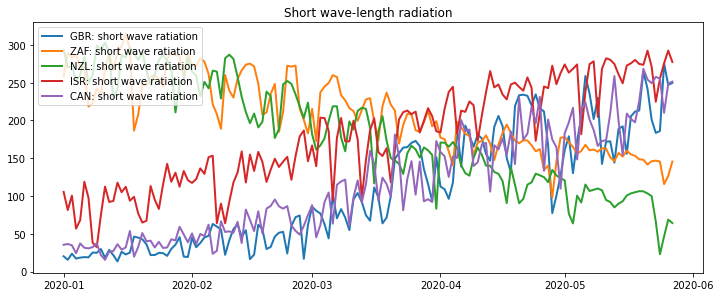

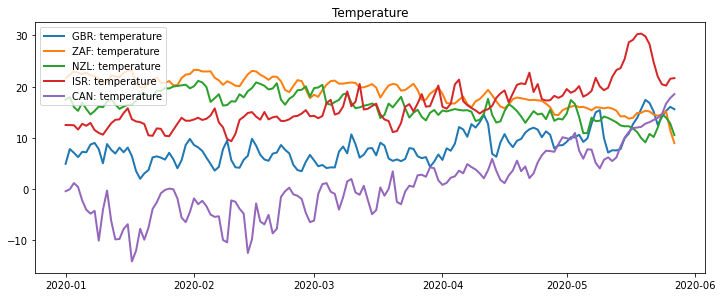

In [24]:
#@title Weather

isos = ['GBR', 'ZAF', 'NZL', 'ISR', 'CAN']

plot_df = df.set_index(['ISO', 'DATE'])

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for idx in range(len(isos)):
  iso = isos[idx]
  ctry = plot_df.loc[iso]
  x = ctry.index  
  y = ctry['weather_precipitation_mean']  
  ax.plot(x, y, '-', linewidth=2,
          label=iso + ': precipitation')
fig.subplots_adjust(bottom=0.3)
ax.legend(loc='upper left', fontsize=10)
ax.set_title('Precipitation')

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for idx in range(len(isos)):
  iso = isos[idx]
  ctry = plot_df.loc[iso]
  x = ctry.index  
  y = ctry['weather_humidity_mean']
  ax.plot(x, y, '-', linewidth=2,
          label=iso + ': humidity')
fig.subplots_adjust(bottom=0.3)
ax.legend(loc='upper left', fontsize=10)
ax.set_title('Humidity')

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for idx in range(len(isos)):
  iso = isos[idx]
  ctry = plot_df.loc[iso]
  x = ctry.index  
  y = ctry['weather_sw_radiation_mean']
  ax.plot(x, y, '-', linewidth=2,
          label=iso + ': short wave ratiation')
fig.subplots_adjust(bottom=0.3)
ax.legend(loc='upper left', fontsize=10)
ax.set_title('Short wave-length radiation')

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for idx in range(len(isos)):
  iso = isos[idx]
  ctry = plot_df.loc[iso]
  x = ctry.index  
  y = ctry['weather_temperature_mean']
  ax.plot(x, y, '-', linewidth=2,
          label=iso + ': temperature')
fig.subplots_adjust(bottom=0.3)
ax.legend(loc='upper left', fontsize=10)
ax.set_title('Temperature');
